## Funciones y Parametrización

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Como vimos en la ayudantía 1, las funciones nos permiten guardar una serie de instrucciones que queramos usar repetidamente en una sola línea de código.

¿Por qué usar funciones?
- Nos permiten reutilizar código
- Permiten modulizar (separar) la lógica de nuestro código en partes más pequeñas y fáciles de debuggear
- Ayudan a la legibilidad de nuestro código (siempre que usemos nombres entendibles para ellas)

Vamos a trabajar con datos de aplicantes a créditos y si les aprobaron el crédito o no (descargados desde [Kaggle](https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction?resource=download)), crear un modelo que prediga si una aplicación va a ser aceptada, validarlo y ajustarlo. Luego vamos a traspasar esto a funciones para que sea más fácil reutilizarlo y parametrizar lo que podamos para que sea aún más fácil reutilizar nuestro código.

In [90]:
# Leemos nuestros datos desde Google Drive
url = "https://drive.google.com/uc?id=1te9tcKALL0pZxIZsgoAUQ4Z7WqV8OD4R"
df = pd.read_csv(url)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [92]:
df.Loan_Status.value_counts()

Y    271
N    110
Name: Loan_Status, dtype: int64

Primero vamos a encodear nuestras variables categóricas (incluyendo la target):

In [93]:
categorical_vars = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Property_Area']
encoded_feature_names = []
for var in categorical_vars:
    dummies = pd.get_dummies(df[var], prefix=var, prefix_sep="_")
    df = pd.concat([df, dummies[dummies.columns[1:]]], axis = 1)
    encoded_feature_names = encoded_feature_names + list(dummies.columns[1:])

df['Loan_Status'] = 1*(df['Loan_Status'] == 'Y')

In [94]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,...,Property_Area,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,...,Rural,0,1,1,1,0,0,0,0,0
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,...,Urban,1,1,1,0,0,0,1,0,1
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,...,Urban,1,1,1,0,0,0,0,0,1
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,...,Urban,1,1,0,0,0,0,0,0,1
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,...,Urban,1,1,1,0,0,0,0,0,1


In [95]:
encoded_feature_names

['Gender_Male',
 'Married_Yes',
 'Dependents_1',
 'Dependents_2',
 'Dependents_3+',
 'Self_Employed_Yes',
 'Property_Area_Semiurban',
 'Property_Area_Urban']

Ahora separamos en Train y Test Set

In [96]:
df = df.dropna()
X = df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'] + encoded_feature_names]
y = df['Loan_Status']

print(f'Variables explicativas: {X.columns.values}')
print(f'Variable explicada: {y.name}')

Variables explicativas: ['ApplicantIncome' 'CoapplicantIncome' 'LoanAmount' 'Loan_Amount_Term'
 'Credit_History' 'Gender_Male' 'Married_Yes' 'Dependents_1'
 'Dependents_2' 'Dependents_3+' 'Self_Employed_Yes'
 'Property_Area_Semiurban' 'Property_Area_Urban']
Variable explicada: Loan_Status


In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Vamos a partir tratando de modelar la probabilidad de aprobar un crédito usando una regresión logística

In [121]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000, random_state=0)

In [122]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [123]:
list(zip(feature_cols, lr.coef_[0]))

[('ApplicantIncome', -6.202489672125801e-05),
 ('CoapplicantIncome', -3.914706289473847e-05),
 ('LoanAmount', 0.0010442026743641526),
 ('Loan_Amount_Term', -0.00519255747705112),
 ('Credit_History', 3.05573874429025),
 ('Gender_Male', 0.13165013143286666),
 ('Married_Yes', 0.2861148095318108),
 ('Dependents_1', -0.28858539671961025),
 ('Dependents_2', -0.045412396138854484),
 ('Dependents_3+', -0.18294993094816298),
 ('Self_Employed_Yes', -0.12066988969628287),
 ('Property_Area_Semiurban', 0.7744104519912399),
 ('Property_Area_Urban', -0.07663785648347508)]

Vamos a evaluar nuestro modelo usando el Accuracy

In [124]:
from sklearn.metrics import accuracy_score
print(np.round(accuracy_score(y_test, lr.predict(X_test)),2))

0.87


Revisemos también las otras métricas comunes:

In [125]:
from sklearn.metrics import precision_score, f1_score
pred = lr.predict(X_test)

accuracy = np.round(accuracy_score(y_test, pred),2)
precision = np.round(precision_score(y_test, pred),2)
f1 = np.round(f1_score(y_test, pred),2)

table = {'Medida': ['Accuracy', 'Precision', 'F1'],
         'Valor': [accuracy, precision, f1]}

pd.DataFrame.from_dict(table)

,Medida,Valor
0,Accuracy,0.87
1,Precision,0.88
2,F1,0.92


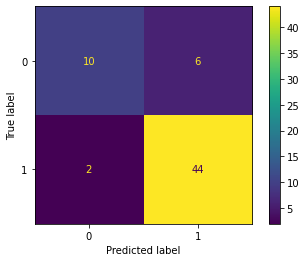

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, lr.predict(X_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Ahora vamos a tratar de mejorar nuestro modelo usando GridSearch y Cross Validation para tunear los hiperparámetros

In [127]:
from sklearn.model_selection import GridSearchCV
parameters_lr = {'fit_intercept':[False, True],
                 'C': [0.0001, 0.001, 0.1, 1, 2, 10]}

gridsearch_lr = GridSearchCV(lr, param_grid=parameters_lr)

gridsearch_lr.fit(X_train, y_train)

print(gridsearch_lr.best_params_)

{'C': 1, 'fit_intercept': True}


In [128]:
print(np.round(accuracy_score(y_test, gridsearch_lr.predict(X_test)),2))

0.87


¿Cómo podríamos pasar toda esta lógica a funciones?

In [135]:
def split_X_y(df):
    X = df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'] + encoded_feature_names]
    y = df['Loan_Status']
    return train_test_split(X, y, test_size=0.2, random_state=0)


def tune_logistic_regression(X_train, y_train):
    
    lr = LogisticRegression(solver = 'newton-cg',max_iter=10000)

    parameters_lr = {'fit_intercept':[False, True],
                 'C': [0.0001, 0.001, 0.1, 1, 2, 10]}

    gridsearch_lr = GridSearchCV(lr, param_grid=parameters_lr)

    gridsearch_lr.fit(X_train, y_train)

    return gridsearch_lr

def train_and_tune_logistic_regression(df):
    X_train, X_test, y_train, y_test = split_X_y(df)

    return tune_logistic_regression(X_train, y_train), X_test, y_test

def print_metrics(y_true, pred):
    accuracy = np.round(accuracy_score(y_true, pred),2)
    precision = np.round(precision_score(y_true, pred),2)
    f1 = np.round(f1_score(y_test, pred),2)

    table = {'Medida': ['Accuracy', 'Precision', 'F1'],
            'Valor': [accuracy, precision, f1]}

    print(pd.DataFrame.from_dict(table))

In [136]:
model, X_test, y_test = train_and_tune_logistic_regression(df)
print_metrics(y_test, model.predict(X_test))

      Medida  Valor
0   Accuracy   0.87
1  Precision   0.88
2         F1   0.92


¿Qué más podríamos parametrizar o separar para hacer aún más reutilizable esta función?

- Los nombres de las columnas de features y target que usaremos
- El tipo de modelo a utilizar
- Los parámetros sobre los que hacer el GridSearch
- No necesitamos hacer el splitting de nuevo cada vez que queramos fittear un modelo

Veamos cómo quedaría con esto:

In [138]:
def split_X_y(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=0)


def tune_model(model, model_params, X_train, y_train):

    gridsearch = GridSearchCV(model, model_params)

    gridsearch.fit(X_train, y_train)

    return gridsearch

In [139]:
model = LogisticRegression(max_iter=10000)
parameters_lr = {'fit_intercept':[False, True],
                 'C': [0.0001, 0.001, 0.1, 1, 2, 10]}

target_col = 'Loan_Status'
feature_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'] + encoded_feature_names

X_train, X_test, y_train, y_test = split_X_y(df, feature_cols, target_col)

model = tune_model(model, parameters_lr, X_train, y_train)
print_metrics(y_test, model.predict(X_test))

      Medida  Valor
0   Accuracy   0.87
1  Precision   0.88
2         F1   0.92


Ahora aprovechemos esta función parametrizada para entrenar otro tipo de modelo de clasificación y compararlos

In [141]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=1)
parameters_tree = {'criterion':["gini", "entropy", "log_loss"],
                   'max_depth': [5,10,15],
                   'max_features': ['sqrt', 'log2']}

model_tree = tune_model(tree_clf, parameters_tree, X_train, y_train)
print_metrics(y_test, model_tree.predict(X_test))

      Medida  Valor
0   Accuracy   0.85
1  Precision   0.88
2         F1   0.91


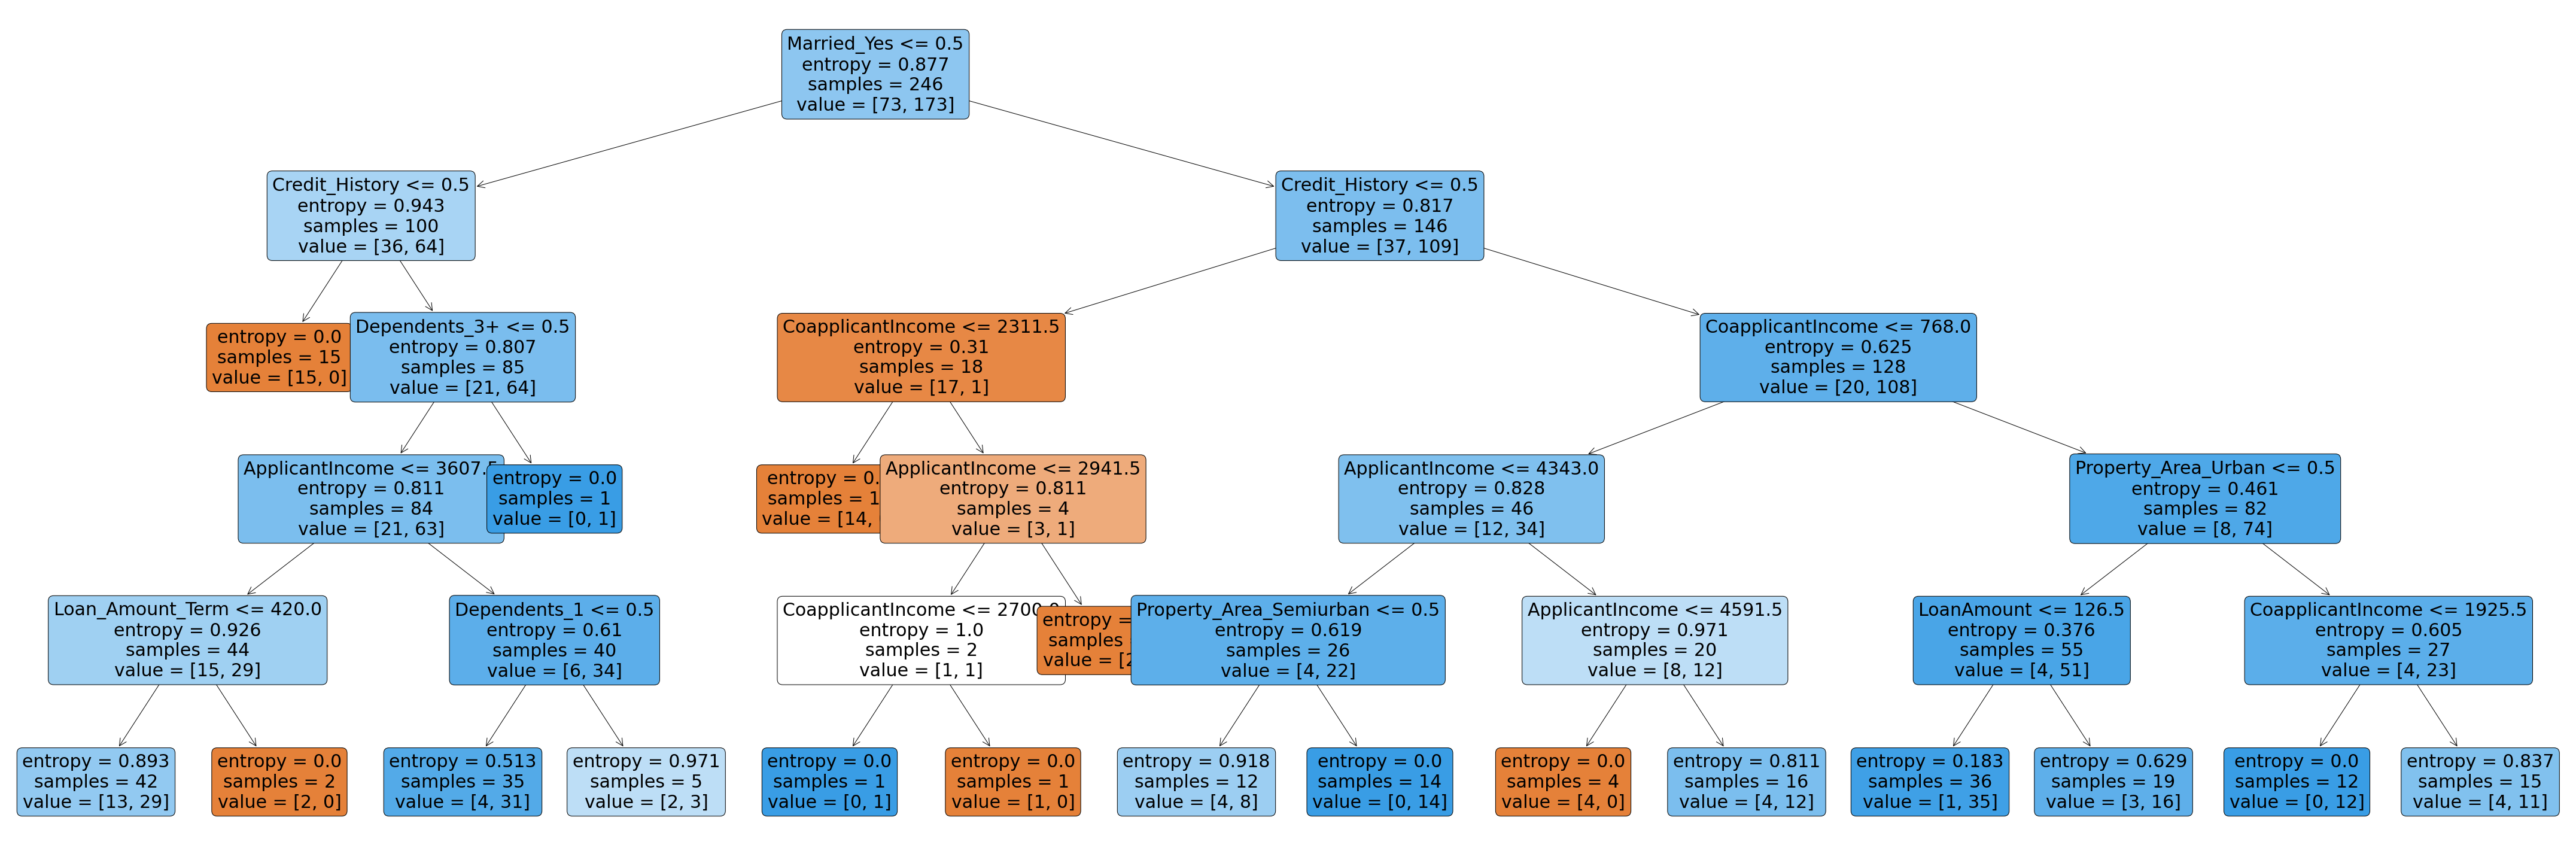

In [142]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,20))
plot_tree(
    model_tree.best_estimator_,
    feature_names = feature_cols,
    filled=True,
    fontsize=30,
    rounded = True)
plt.tight_layout()
plt.show()

### Propuesto: Resolver el problema del desbalance de clases en nuestra target